In [25]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.datasets import mnist
from keras import backend as K

In [26]:
# 1 - download the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [27]:
# 2 - Shuffle the training data
from sklearn.utils import shuffle

# Combine features and labels for shuffling
train_data = list(zip(x_train, y_train))

# Shuffle the data
shuffled_data = shuffle(train_data)

# Unzip the shuffled data
x_train, y_train = zip(*shuffled_data)

# Convert back to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Print the dimensions of the data
print("Dimensions of Shuffled Training Data:")
print("Features (x_train):", x_train.shape)
print("Labels (y_train):", y_train.shape)
print("Features (x_test):", x_test.shape)
print("Labels (y_test):", y_test.shape)


Dimensions of Shuffled Training Data:
Features (x_train): (60000, 28, 28)
Labels (y_train): (60000,)
Features (x_test): (10000, 28, 28)
Labels (y_test): (10000,)


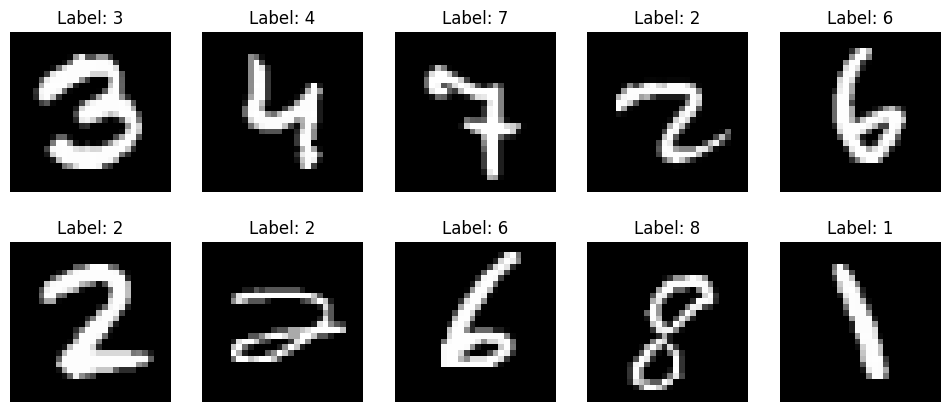

In [28]:
# 3 - Display the first 10 training data samples with labels
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [29]:
# 4 - normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

In [30]:
# 5 - Convert labels to categorical representation (one-hot encoding)
from keras.utils import to_categorical

num_classes = 10  # Assuming there are 10 classes (digits 0-9)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [33]:
# 6 - design the convolutional model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
# Max pooling layer 1
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# Max pooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='last_conv_layer'))
# Max pooling layer 3
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
# 7 - train and evaluate the model
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/15
938/938 [==============================] - 7s 6ms/step - loss: 0.1788 - accuracy: 0.9450 - val_loss: 0.0508 - val_accuracy: 0.9846
Epoch 2/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.0435 - val_accuracy: 0.9855
Epoch 3/15
938/938 [==============================] - 4s 5ms/step - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0319 - val_accuracy: 0.9896
Epoch 4/15
938/938 [==============================] - 5s 6ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0344 - val_accuracy: 0.9888
Epoch 5/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0347 - val_accuracy: 0.9884
Epoch 6/15
938/938 [==============================] - 7s 7ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0291 - val_accuracy: 0.9908
Epoch 7/15
938/938 [==============================] - 8s 9ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0244 - val_accuracy: 0.9911
Epoch 

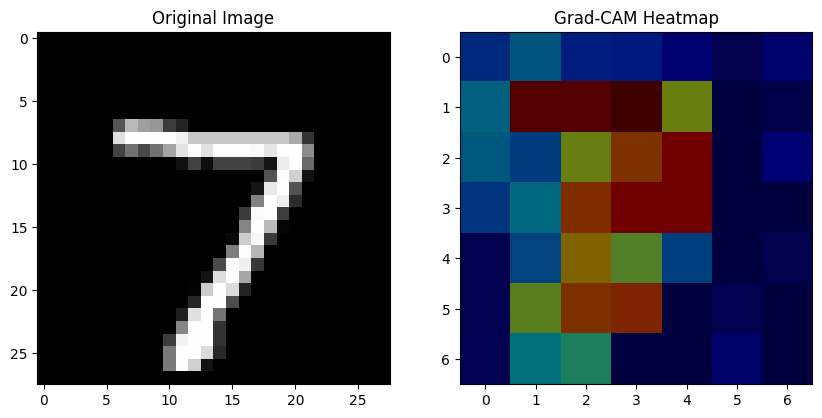

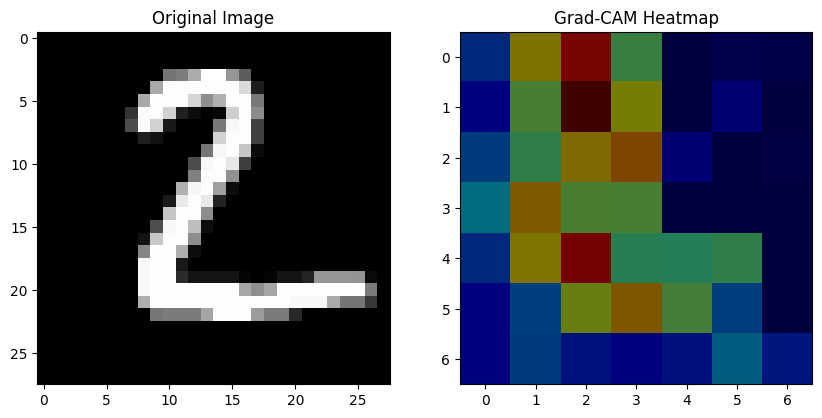

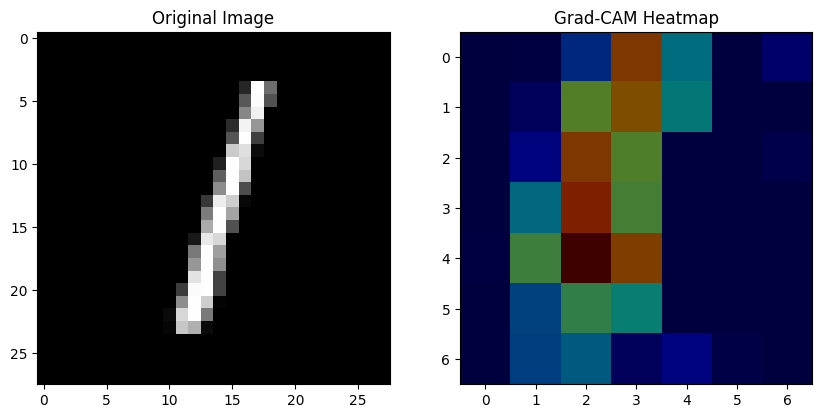

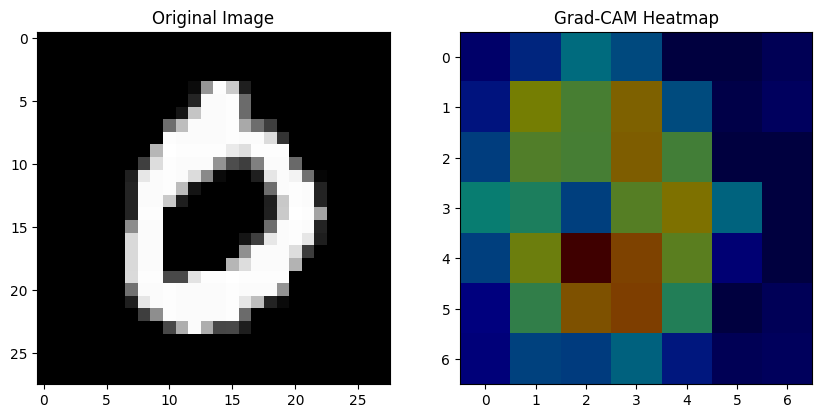

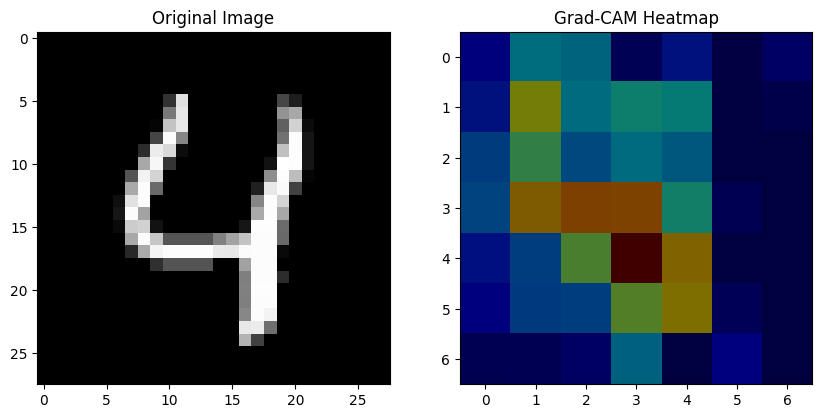

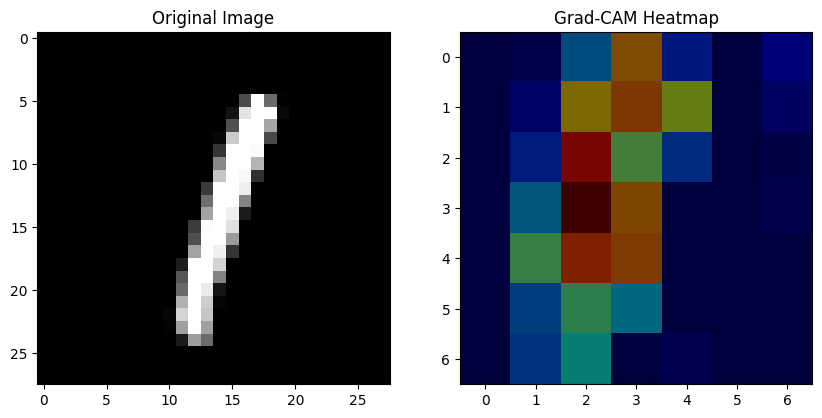

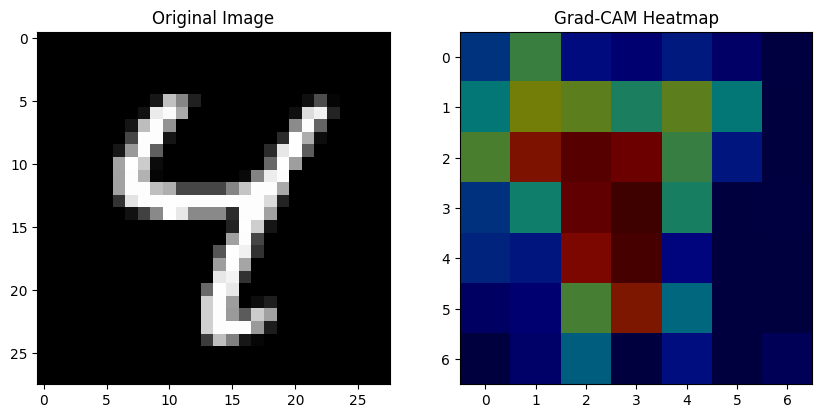

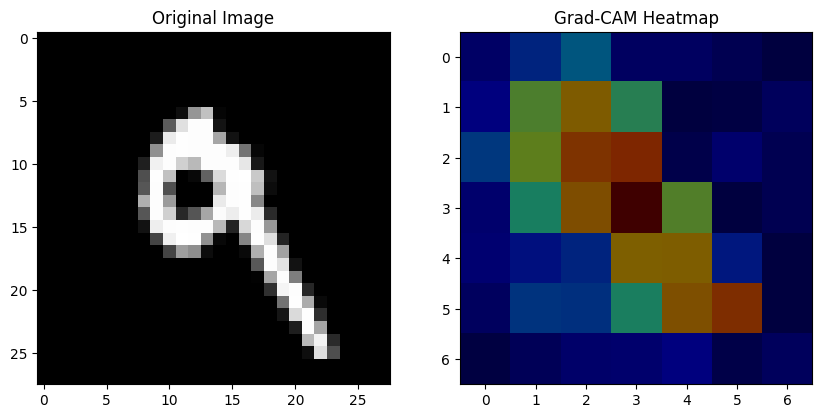

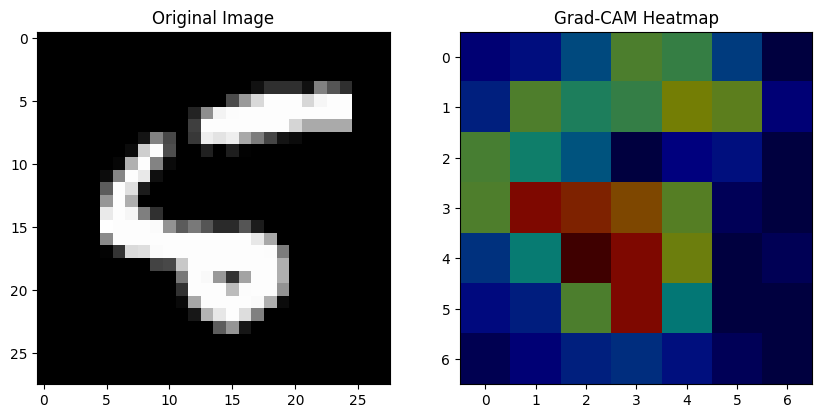

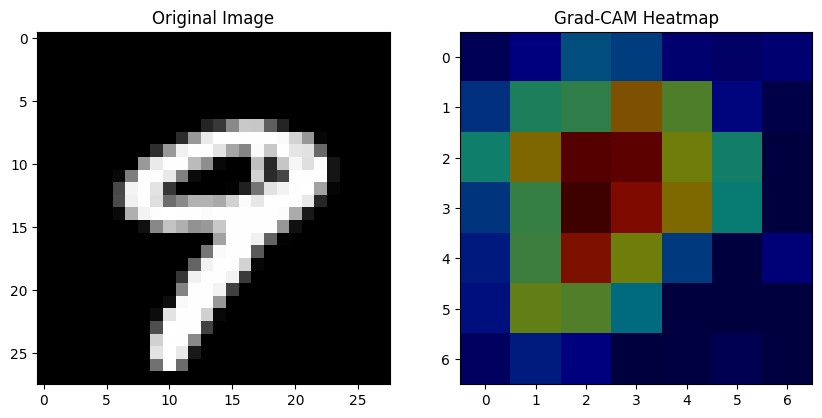

In [39]:
import tensorflow as tf
from keras import backend as K
from skimage.transform import resize

def grad_cam(img):
  last_conv_layer = model.get_layer('last_conv_layer')
  heatmap_model = tf.keras.models.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])


  with tf.GradientTape() as tape:
      conv_outputs, predictions = heatmap_model(x_test[:10].reshape(-1, 28, 28, 1))
      loss = predictions[:, tf.argmax(predictions[0])]
      grads = tape.gradient(loss, conv_outputs)
      gradients_pool = K.mean(grads, axis = (0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(gradients_pool, conv_outputs), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap


for i in range(10):
    img = x_test[i]
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('Original Image')

    # Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(grad_cam(img)[i], cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap')

    plt.show()
